## **IMPORT LIBRARY**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform

## **LOAD DATA**

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/01.%20Machine%20Learning/06.%20Week%206/Datasets/clusteringcampaign.csv", delimiter='\t')
df = df.drop(columns=["ID", "Dt_Customer", "Z_CostContact", "Z_Revenue"])
df = df.dropna()

# Encode kategorikal
label_enc = LabelEncoder()
for col in ["Education", "Marital_Status"]:
    df[col] = label_enc.fit_transform(df[col])

# **SCALING**

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

## **ELBOW METHOD & SILHOUETTE SCORE**

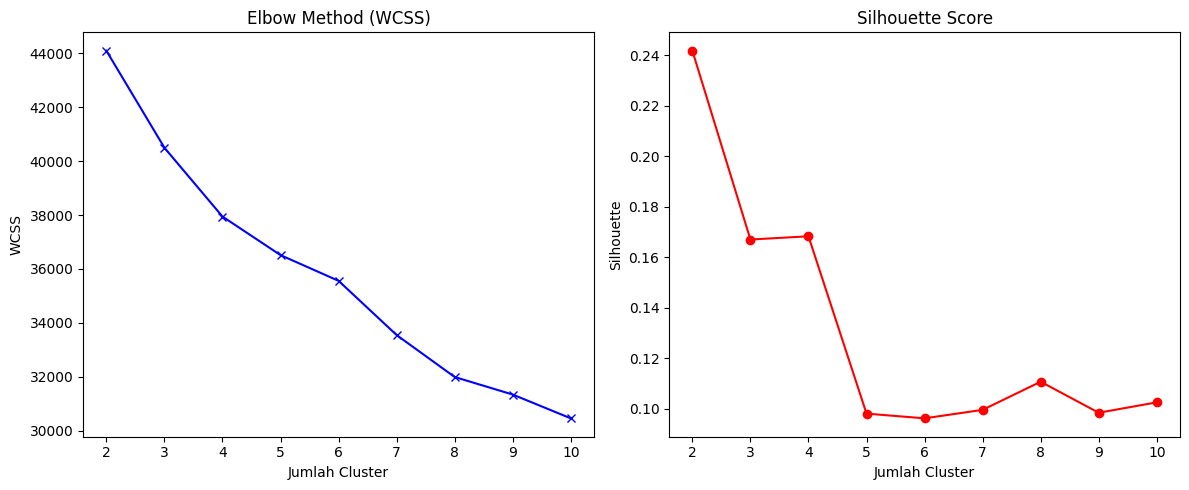

In [4]:
wcss = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled)
    wcss.append(model.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K, wcss, 'bx-')
plt.title("Elbow Method (WCSS)")
plt.xlabel("Jumlah Cluster")
plt.ylabel("WCSS")

plt.subplot(1,2,2)
plt.plot(K, silhouette_scores, 'ro-')
plt.title("Silhouette Score")
plt.xlabel("Jumlah Cluster")
plt.ylabel("Silhouette")

plt.tight_layout()
plt.show()



> Grafik Elbow Method menunjukkan bahwa penurunan WCSS mulai melambat di sekitar jumlah cluster 4 atau 5, menandakan titik optimal (elbow) ada di sana. Sementara itu, grafik Silhouette Score menunjukkan skor tertinggi pada cluster 2, tapi menurun drastis setelahnya. Meski k=2 paling stabil, model tersebut mungkin terlalu sederhana, sehingga kompromi terbaik berada di antara k=3 hingga k=4 yang masih memiliki skor siluet cukup baik dan struktur cluster yang lebih bermakna.



## **FIT CLUSTERING (K=4 sebagai contoh)**

In [5]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
agglo = AgglomerativeClustering(n_clusters=k)

labels_kmeans = kmeans.fit_predict(X_scaled)
labels_agglo = agglo.fit_predict(X_scaled)

## **EVALUASI CLUSTERING**

In [7]:
def dunn_index(X, labels):
    distances = squareform(pdist(X))
    unique_clusters = np.unique(labels)
    intra_dists = [np.max(distances[np.ix_(labels == c, labels == c)]) for c in unique_clusters]
    inter_dists = [np.min(distances[np.ix_(labels == i, labels == j)])
                   for i in unique_clusters for j in unique_clusters if i < j]
    return np.min(inter_dists) / np.max(intra_dists)

def evaluate_model(X, labels, model_name):
    print(f"📊 Evaluation for {model_name}")
    print("Silhouette Score:        {:.4f}".format(silhouette_score(X, labels)))
    print("Calinski-Harabasz Index: {:.4f}".format(calinski_harabasz_score(X, labels)))
    print("Davies-Bouldin Index:    {:.4f}".format(davies_bouldin_score(X, labels)))
    print("Dunn Index:              {:.4f}".format(dunn_index(X, labels)))
    print("-" * 40)

evaluate_model(X_scaled, labels_kmeans, "KMeans")
evaluate_model(X_scaled, labels_agglo, "Agglomerative")

📊 Evaluation for KMeans
Silhouette Score:        0.1683
Calinski-Harabasz Index: 339.2458
Davies-Bouldin Index:    2.1731
Dunn Index:              0.0306
----------------------------------------
📊 Evaluation for Agglomerative
Silhouette Score:        0.1200
Calinski-Harabasz Index: 288.5127
Davies-Bouldin Index:    2.5034
Dunn Index:              0.0497
----------------------------------------


# **PENJELASAN MATEMATIKA METRIK**
**1. Within-Cluster Sum of Squares (WCSS)**
  
  Penjelasan:
  
  Metrik ini menghitung jumlah total kuadrat jarak antara setiap titik data dan centroid (titik pusat) dari cluster tempat titik tersebut berada.Artinya, WCSS mengukur seberapa rapat data dalam suatu cluster—semakin dekat titik ke centroid-nya, semakin baik.
$$
WCSS = \sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2
$$
* 𝐶𝑖 : cluster ke-i
* 𝜇𝑖 : centroid dari cluster ke-i
* 𝑥 : titik data dalam cluster
> Semakin kecil WCSS, semakin padat cluster-nya

**2. Silhouette Coefficient**
$$
s(i) = \frac{b(i) - a(i)}{\max \{ a(i), b(i) \}}
$$
* 𝑎(𝑖) : rata-rata jarak antar 𝑖 dan semua titik dalam cluster-nya.
* 𝑏(𝑖) : rata-rata jarak antar 𝑖 dan semua titik di cluster tetangga terdekat.
> Nilai antara -1 dan 1. Semakin tinggi, semakin baik pemisahan cluster.

**3. Calinski-Harabasz Index**
  
  Penjelasan:
  
  Mengukur rasio dispersi antar cluster dengan dispersi dalam cluster.
$$
CH = \frac{\text{Tr}(B_k)}{\text{Tr}(W_k)} \cdot \frac{n - k}{k - 1}
$$
* Tr(𝐵𝑘) : dispersi antar cluster (antara pusat cluster dan pusat global)
* Tr(𝑊𝑘) : dispersi dalam cluster
* 𝑛 : total sample
* 𝑘 : jumlah cluster
> Semakin tinggi CH, semakin baik pemisahan antar cluster.

**4. Davies-Bouldin Index**
$$
DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \ne i} \left( \frac{\sigma_i + \sigma_j}{d(c_i, c_j)} \right)
$$
* 𝜎𝑖 : rata-rata jarak titik ke centroid cluster 𝑖
* 𝑑(𝑐𝑖,𝑐𝑗) : jarak antar centroid cluster
𝑖 dan 𝑗
> Semakin rendah DB, semakin baik kualitas clustering.

**5. Dunn Index**
$$
\text{Dunn} = \frac{\min\limits_{i \ne j} \left( d(C_i, C_j) \right)}{\max\limits_{k} \left( \delta(C_k) \right)}
$$
* 𝑑(𝐶𝑖,𝐶𝑗) : jarak minimum antar cluster 𝐶𝑖 dan 𝐶𝑗
* 𝛿(𝐶𝑘) : diameter maksimum cluster 𝑘
> Nilai tinggi = cluster terpisah baik dan padat secara internal.